# Planetary mass classification

This are classification is based on planetary mass and total mass for each planetary system. The data are getting from http://exoplanet.eu/

The data taking into account are those that have mass value and mass uncertainty. 

We employ Gaussian Mixture Model (GMM's), as a way to find clusters of points in our dataset that share some common characteristics, clustering an unsupervised learning problem. consult: https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95, for explanation.

In [1]:
import pandas as pd 
import numpy as np
from scipy.stats import norm #normal distribution
import random
from sklearn.mixture import GaussianMixture #gaussian mixture
import matplotlib.pyplot as plt
%matplotlib inline

#Reading the data:
data = pd.read_csv('exoplanet.eu_catalog.csv', 
                   usecols=['star_name','mass','mass_error_min'])

#It replaces the inf values and removes the NaN values:
data = data.replace([np.inf, -np.inf], np.nan) 
planet_data = data.dropna(subset=['mass','mass_error_min'])
sistem_data = data.dropna(subset=['mass','mass_error_min','star_name'])

The variable `sistem_data`, has the planetary masses for planetary sistems that are known, it means ins't NaN values in the column `'star_name'`. There are 31 planetary systems without star name.

In [2]:
#print(len(planet_data),len(sistem_data))

### Function: Information Criterion 

First, we define a function wich gets the information criteria for different numbers of components (the number of mixture components), in order to obtain the minimum value of criterium. The lowest BIC/AIC is preferred.

Then, it plots the BIC and AIC values to observe their behavior.

In [3]:
# "mass" must be a clumn of the dataframe (in this case an array of masses)
# "times" is the number of clusters in the criteria: AIC and BIC
# returns de value of the AIC and BIC criteria. also, returns the plot of the criteria.

def inf_criterion(times, mass):
    
    bic, aic = [], []
    
    for i in range(times):
        i += 1
        gmm = GaussianMixture(i, covariance_type='full', random_state=0)
        gmm.fit(mass)
        bic+=[gmm.bic(mass.values)]
        aic+=[gmm.aic(mass.values)]
    
    criteria = [bic,aic]  
    min_criteria = [min(criteria[0]),#/max(criteria[0]),
                    min(criteria[1])]#/max(criteria[1])]

    #comparison between AIC and BIC criteria (plot)
    figure, ax = plt.subplots(1, 2, sharex='col', 
                              sharey='row', figsize=(10, 5))
    label = ['BIC','AIC']

    for i,criterium in enumerate(criteria):
        ax[i].plot(range(len(criteria[i])),criteria[i],#/max(criteria[i]), 
                   "o", c="C1",label=label[i])
        ax[i].plot(range(len(criteria[i])),criteria[i],#/max(criteria[i]), 
                   lw="2", label=label[i])
        ax[i].plot(range(len(criteria[i])),
                   np.ones(len(criteria[i]))*min_criteria[i],"--")
        ax[i].set(xlabel='n_components')
        ax[i].legend(fontsize=11)
    ax[0].set(ylabel='criterium value')
    plt.subplots_adjust(wspace = .05)
    
    print('N. of clusters BIC = '+str(criteria[0].index(min(criteria[0]))+1))
    print('N. of clusters AIC = '+str(criteria[1].index(min(criteria[1]))+1))

    return [bic,aic]

### Function: Classification

Once the criterion is applied, the classification comes. Here, we employ the `n_components` where the lowest BIC/AIC is preferred. 

The gaussian plots are generated in order to represent the clusters. 

In [4]:
# "mass" must be a clumn of the dataframe (in this case an array of masses)
#'n_components' is the number of clusters for the lowest BIC/AIC.

def classification(n_components,mass,log=False):
    gmm = GaussianMixture(n_components, covariance_type='full',random_state=0)
    gmm.fit(mass.values)
    cluster_label = gmm.predict(mass.values)
    
    #Figures:
    CL = cluster_label
    color=["C"+str(CL[i]+1) for i in range(len(cluster_label))]
    x=np.linspace(mass.values.min(),mass.values.max(),1000)
        
    figure, ax = plt.subplots(1, 2, sharex='col', 
                              sharey='row', figsize=(10, 5))
    
    #Gaussians:
    for c in range(n_components):
        ax[0].plot(x,norm.pdf(x,gmm.means_[c],
                              gmm.covariances_[c])[0]/norm.pdf(x,gmm.means_[c],
                                                               gmm.covariances_[c])[0].max())

    #Scatter:
        Mass_a=mass.values[CL==c]    
        ax[0].plot(Mass_a,
                   np.zeros(len(Mass_a)),"o",label='cluster '+str(c+1))#,
#                   color='C'+str(c))
        ax[1].plot(mass,gmm.predict_proba(mass)[:,c],"o",
                   label='P_cluster '+str(c+1))
    
    if log==True:
        ax[0].set(xlabel=r'$\log_{10}$(Mass)')
        ax[1].set(xlabel=r'$\log_{10}$(Mass)')
    else:
        ax[0].set(xlabel=r'Mass')
        ax[1].set(xlabel=r'Mass')
        
    ax[0].set(ylabel=r'Normal distribution')
    ax[1].set(ylabel=r'Posterior probabilities')

    ax[0].legend()  
    ax[1].legend() 
        
    plt.subplots_adjust(wspace = .1)

### Function: Fraction changed

This function generates 1000 synthetic systems per each data (the mass an its uncertainty). We take draws from this, and stimate the validation of the classification.  

The posteriror probabilities are determinated by the function `gmm.predict()`

In [5]:
#'dawns' is the number of synthetic systems per each data known
#'data' is a DataFrame of the data, with column "mass"
#'n_components' is the number of clusters for the lowest BIC/AIC.

def fraction_changed(n_components, dawns, data, log=False):
    draws=[]

    #1000 draws per planetary mass or systrem mass:
    for i in range(len(data.values)):
        masses=np.random.normal(data.mass.values[i],
                                data.mass_error_min.values[i],
                                dawns)
        draws += [masses]
        
    #fraction of the synthttic systems wich change classification group:
    fraction_changed = []
    if log==True:
        mass = np.log10(data[["mass"]])
    else:
        mass = data[["mass"]]
        
    gmm = GaussianMixture(n_components,covariance_type='full',random_state=0)
    gmm.fit(mass.values)
    cluster_label = gmm.predict(mass.values)
    
    for index in range(len(draws)):
        draw_i=np.abs(draws[index][:,np.newaxis])
        orig=gmm.predict(np.array(mass))[index]
        fraction_changed+=[(orig!=gmm.predict(draw_i)).sum()/1000]
    
    return((np.array(fraction_changed)==0).sum()/len(fraction_changed))
    return fraction_changed

## Study for the mass

For the data of mass we carry out the study of clusters and criterion, as a result:

N. of clusters BIC = 10
N. of clusters AIC = 10


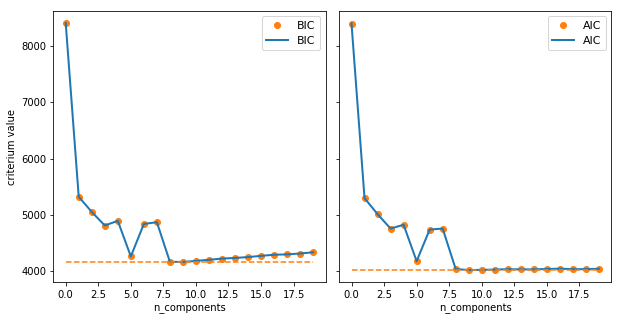

In [6]:
info_mass = inf_criterion(20, planet_data[["mass"]])

Taking the number of clusters as 10, we proceed to carry aut the classification. 

/home/frank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


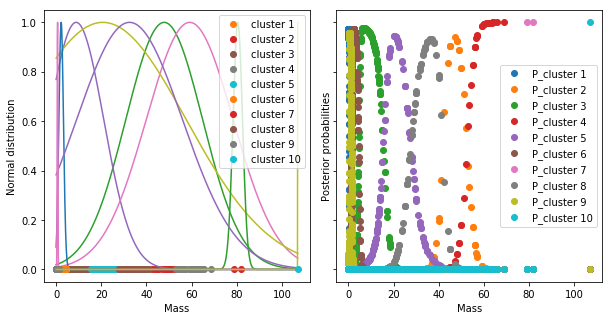

In [7]:
mass_n_clusters=10
mass=planet_data[["mass"]]
class_mass = classification(mass_n_clusters, mass)

Finally the we stimate the validation of the classification. 

In [8]:
frac_mass=fraction_changed(mass_n_clusters,1000,planet_data,False)
print("The fraction of changes = " + str(frac_mass))

The fraction of changes = 0.5429389312977099


## Study for the logarithm of the mass

For the data of mass we carry out the study of clusters and criterion, as a result:

N. of clusters BIC = 3
N. of clusters AIC = 10


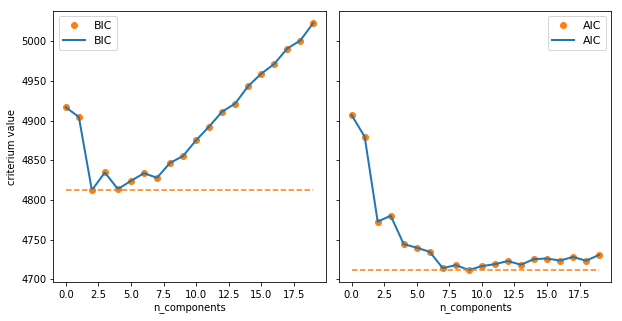

In [9]:
info_logmass = inf_criterion(20, np.log(planet_data[["mass"]]))

Taking the number of clusters as 3, we proceed to carry aut the classification.

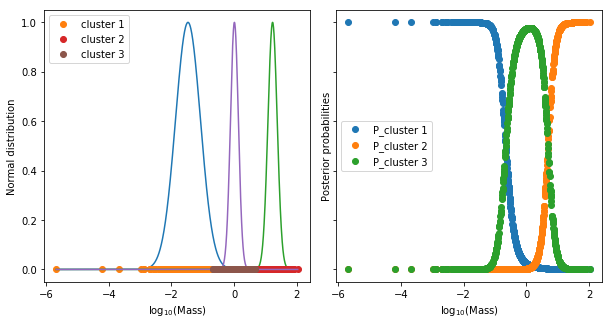

In [10]:
logmass_n_clusters = 3
logmass = np.log10(planet_data[["mass"]])
class_logmass = classification(logmass_n_clusters, logmass, True)

Finally the we stimate the validation of the classification. 

In [11]:
frac_logmass = fraction_changed(logmass_n_clusters,1000,planet_data,True)
print("The fraction of changes = " + str(frac_logmass))

The fraction of changes = 0.08301526717557252


## Study for the total mass per system
(only planetary masses)

$$M_{Tj}=\sum_{i}M_{i,j}$$ 

where $j$ is the number of the systems.

For the data of total mass per system (name of stars), we carry out the study of clusters and criterion, but first was necessary carry aut a propagation of uncertainty, as a result:

In [12]:
uncertanty_squared = sistem_data['mass_error_min'].multiply(sistem_data['mass_error_min'])
sistem_data = sistem_data.assign(uncertanty_squared=sistem_data['mass_error_min'].multiply(sistem_data['mass_error_min']))
sistem_data.head()

,mass,mass_error_min,star_name,uncertanty_squared
1,21.0,3.0,11 Oph,9.0
7,14.0,3.0,1RXS 1609,9.0
8,32.0,6.0,1RXS J235133.3+312720,36.0
14,13.0,1.0,2M 0103-55 (AB),1.0
15,20.0,7.0,2M 0122-24,49.0


Then, the systems are grouped by the name of the star.

In [13]:
masses_system = sistem_data.groupby("star_name")
system = list(masses_system.groups.keys())
Mass_total = masses_system['mass'].sum()
uncertainty = np.sqrt(masses_system['uncertanty_squared'].sum())


system_data = pd.DataFrame({'system_name':system,
                            'mass':Mass_total.tolist(),
                            'mass_error_min':uncertainty.tolist()})
system_data.head()

,system_name,mass,mass_error_min
0,OGLE-2016-BLG-1067L,0.43,0.17
1,11 Oph,21.00,3.00
2,1RXS 1609,14.00,3.00
3,1RXS J235133.3+312720,32.00,6.00
4,2M 1938+46,1.90,0.10


Once the data are grouped by system (mass per system), we carry aut the study of clusters and criterion, as a result:

N. of clusters BIC = 17
N. of clusters AIC = 28


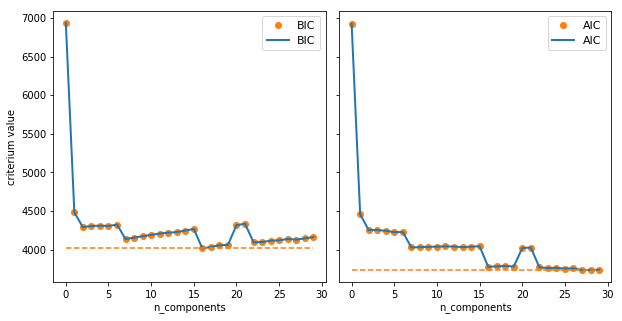

In [14]:
info_Total_mass = inf_criterion(30, system_data[["mass"]])

/home/frank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


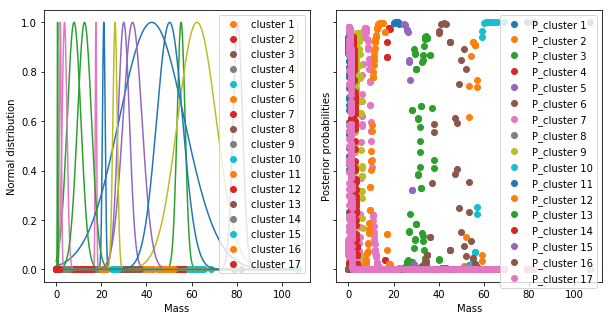

In [15]:
totmass_n_clusters = 17
totmass = system_data[["mass"]]
classif_totmass = classification(totmass_n_clusters, totmass,False)

In [16]:
frac_totmass = fraction_changed(totmass_n_clusters,1000,system_data)
print("the fraction of changes = " + str(frac_totmass))

the fraction of changes = 0.46395348837209305


## Study for the logarithm of the total mass per system
(only planetary masses)

N. of clusters BIC = 5
N. of clusters AIC = 15


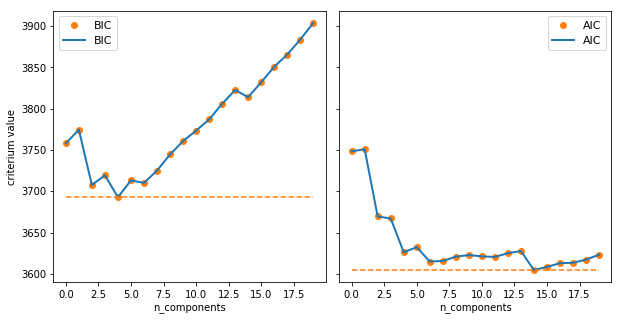

In [17]:
info_tot_logmass = inf_criterion(20, np.log(system_data[["mass"]]))

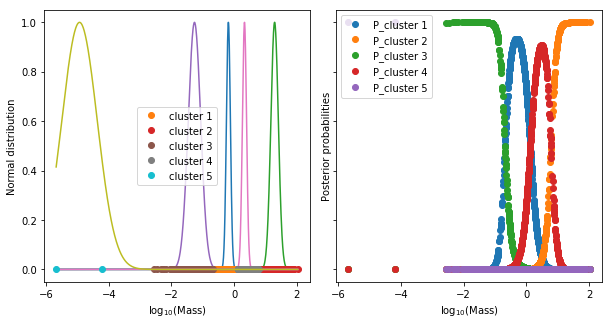

In [18]:
Tot_logmass_n_clusters=5
Tot_logmass=np.log10(system_data[["mass"]])
classif_Tot_logmass = classification(Tot_logmass_n_clusters, 
                                     Tot_logmass,True)

In [19]:
frac_tot_logmass = fraction_changed(Tot_logmass_n_clusters,1000,
                                    system_data,True)
print("The fraction of changes = " + str(frac_logmass))

The fraction of changes = 0.08301526717557252
